In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal=sns.color_palette()
plt.style.use('fivethirtyeight')
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,root_mean_squared_error
import warnings
warnings.filterwarnings("ignore")



In [130]:
df=pd.read_csv(r"C:\ML_Analytics\Time_Series_Forecasting\Data\raw\Hourly_Energy_consumption\PJME_hourly.csv")
df=df.set_index('Datetime')
df.index=pd.to_datetime(df.index)

In [131]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


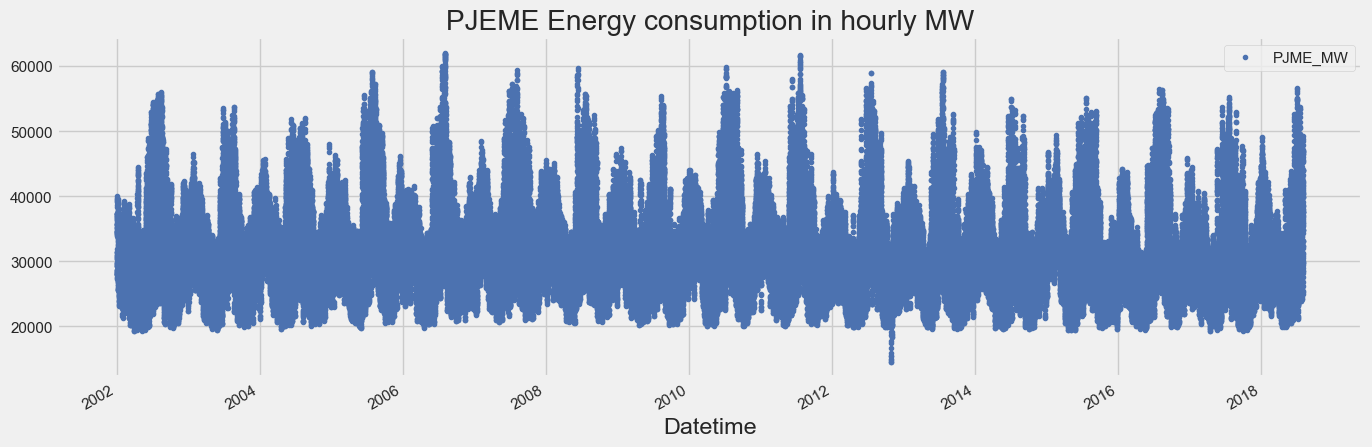

In [132]:
df.plot(style='.',figsize=(15,5),color=color_pal[0],title='PJEME Energy consumption in hourly MW')
plt.show()

# Train/Test Split

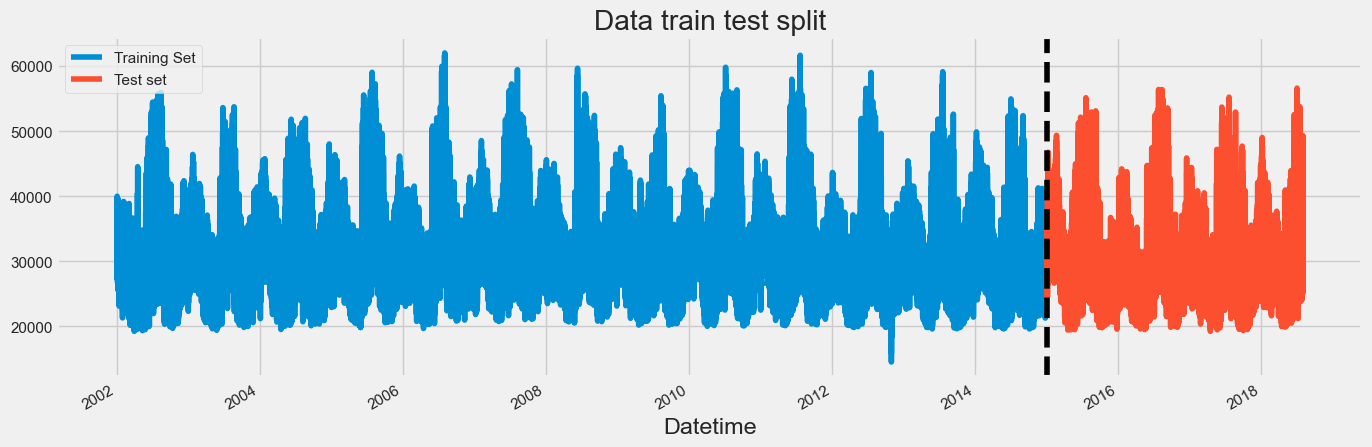

In [133]:
train =df.loc[df.index < '01-01-2015']
test =df.loc[df.index >= '01-01-2015']

fig,ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set',title='Data train test split')
test.plot(ax=ax, label='Test set')
ax.axvline('01-01-2015',color='black',ls='--')
ax.legend(['Training Set','Test set'])
plt.show()

In [134]:
df.sort_index(inplace=True)

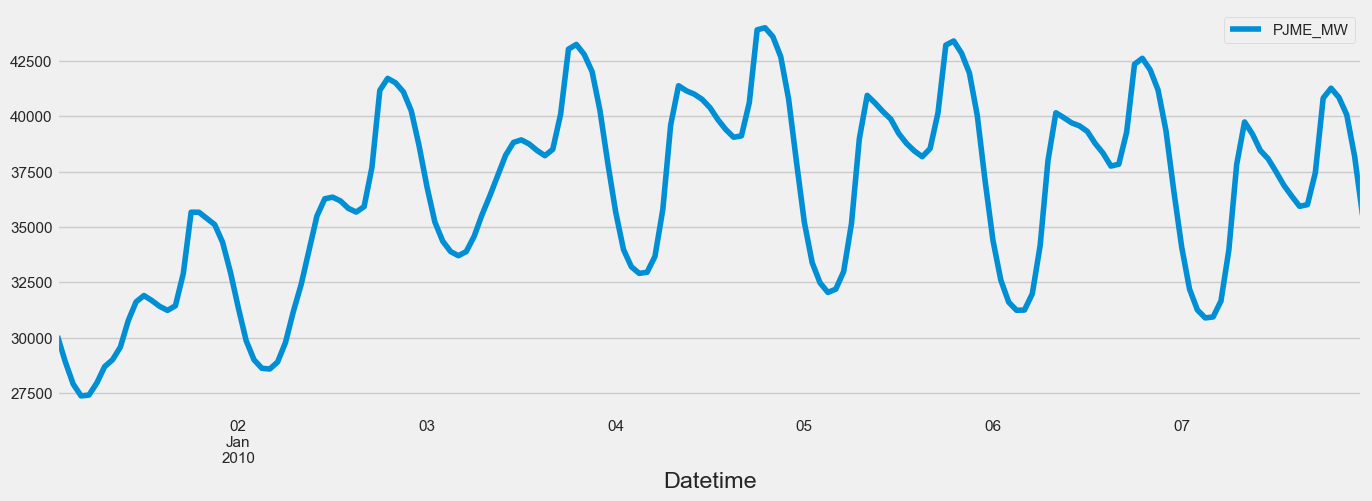

In [135]:
df.loc[(df.index > '01-01-2010') & (df.index <'01-08-2010')].plot(figsize=(15,5))
plt.show()

# Feature Creation

In [137]:
def create_features(df):
    """
    create timeseries features based on time series.index
    """
    df['hour']=df.index.hour
    df['dayofweek']=df.index.day_of_week
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayofyear']=df.index.dayofyear
    return df


In [138]:
df=create_features(df)

# Visualize our Feature/ Target Relationship

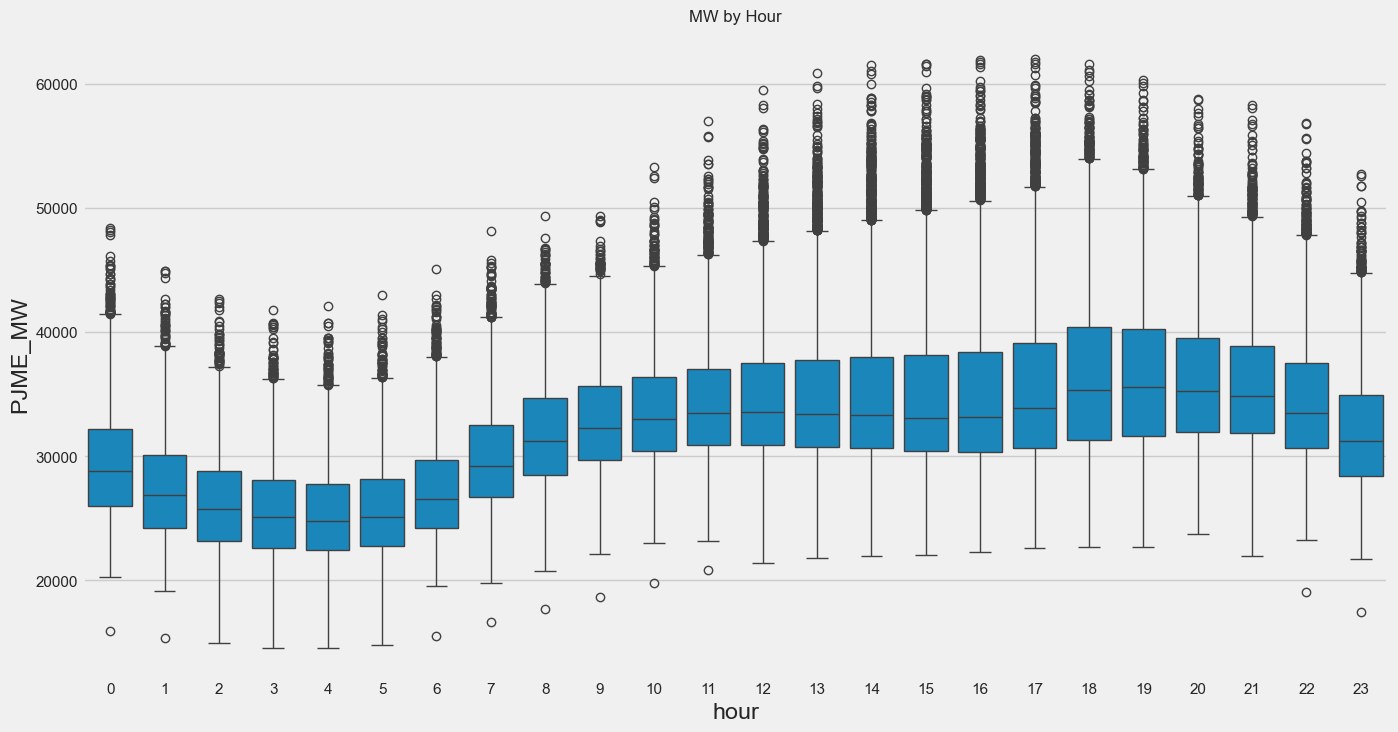

In [139]:
fig,ax=plt.subplots(figsize=(15,8))
sns.boxplot(data=df,x='hour',y='PJME_MW')
sns.set() 
ax.set_title('MW by Hour')
plt.show()


# Create Our Model

In [140]:
model=XGBRegressor(early_stopping_rounds=50,
    n_estimators=500,
    learning_rate=0.01,
    max_depth=10,
    random_state=42
)

In [141]:
train=create_features(train)
test=create_features(test)

Features=['hour','dayofweek','quarter','month','year','dayofyear']
Target='PJME_MW'

x_train=train[Features]
y_train=train[Target]

x_test=test[Features]
y_test=test[Target]

In [142]:
model.fit(x_train,y_train,
eval_set=[(x_train,y_train),(x_test,y_test)],
verbose=True
)

[0]	validation_0-rmse:6401.28838	validation_1-rmse:6476.85802
[1]	validation_0-rmse:6350.92519	validation_1-rmse:6434.96405
[2]	validation_0-rmse:6301.13890	validation_1-rmse:6391.26512
[3]	validation_0-rmse:6251.86244	validation_1-rmse:6350.35270
[4]	validation_0-rmse:6203.20417	validation_1-rmse:6309.08118
[5]	validation_0-rmse:6155.10922	validation_1-rmse:6269.59690
[6]	validation_0-rmse:6107.63015	validation_1-rmse:6230.49020
[7]	validation_0-rmse:6060.84106	validation_1-rmse:6191.25028
[8]	validation_0-rmse:6014.42578	validation_1-rmse:6153.05326
[9]	validation_0-rmse:5968.79390	validation_1-rmse:6114.44429
[10]	validation_0-rmse:5923.50911	validation_1-rmse:6077.36166
[11]	validation_0-rmse:5879.02377	validation_1-rmse:6040.35687
[12]	validation_0-rmse:5834.97623	validation_1-rmse:6004.77290
[13]	validation_0-rmse:5791.67251	validation_1-rmse:5966.48173
[14]	validation_0-rmse:5748.62582	validation_1-rmse:5932.12474
[15]	validation_0-rmse:5706.23943	validation_1-rmse:5895.88581
[1

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


# Feature Importance

<Axes: >

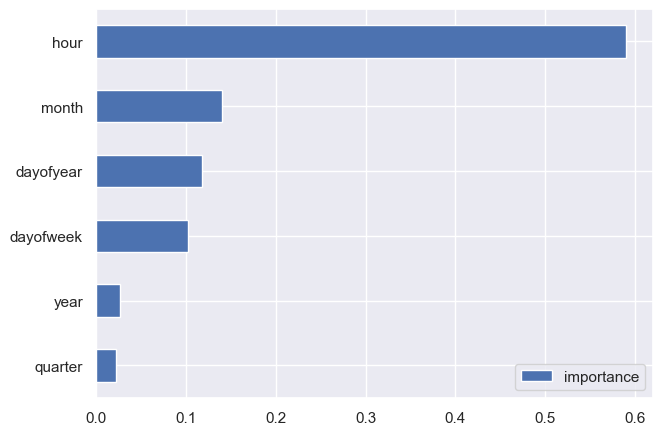

In [143]:
fi=pd.DataFrame(data=model.feature_importances_,index=model.feature_names_in_,columns=['importance'])

fi.sort_values('importance').plot(kind='barh')


In [144]:
fi.head()

,importance
hour,0.590510
dayofweek,0.102396
quarter,0.022293
month,0.139805
year,0.026891


# Forecast on the Test set

In [145]:
test['prediction']= model.predict(x_test)


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   PJME_MW    145366 non-null  float64
 1   hour       145366 non-null  int32  
 2   dayofweek  145366 non-null  int32  
 3   quarter    145366 non-null  int32  
 4   month      145366 non-null  int32  
 5   year       145366 non-null  int32  
 6   dayofyear  145366 non-null  int32  
dtypes: float64(1), int32(6)
memory usage: 5.5 MB


In [153]:
df1=df.merge(test[['prediction']],how='left',left_index=True,right_index=True)

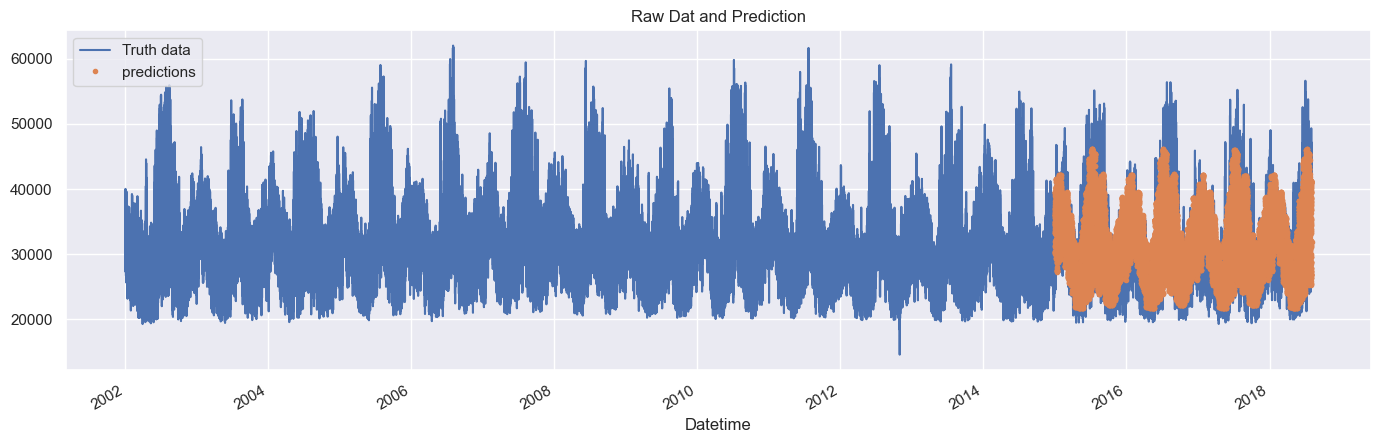

In [158]:
ax=df1[['PJME_MW']].plot(figsize=(15,5))
df1['prediction'].plot(ax=ax,style='.')
plt.legend(['Truth data','predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

# one week data for prediction

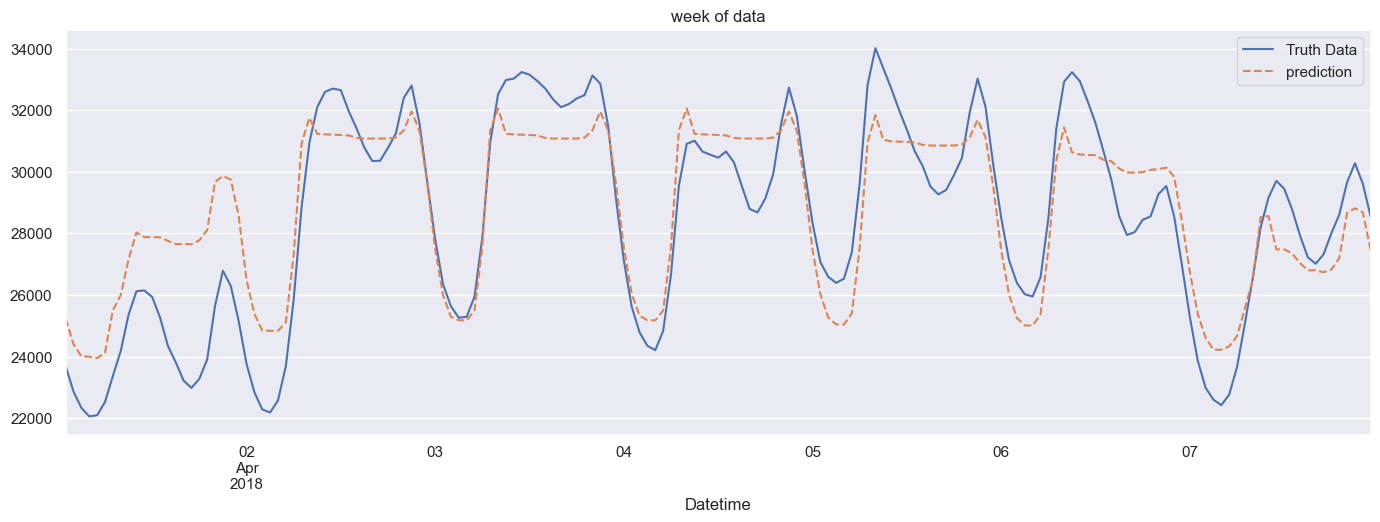

In [160]:
ax=df1.loc[(df1.index >'04-01-2018') & (df1.index <'04-08-2018')]['PJME_MW'].plot(figsize=(15,5),title='week of data')
df1.loc[(df1.index > '04-01-2018') & (df1.index <'04-08-2018')]['prediction'].plot(style='--')
plt.legend(['Truth Data','prediction'])
plt.show()

In [164]:
score=np.sqrt(mean_squared_error(test['PJME_MW'],test['prediction']))
print(f'RMSE score on test score: {score:.2f}')

RMSE score on test score: 3924.22


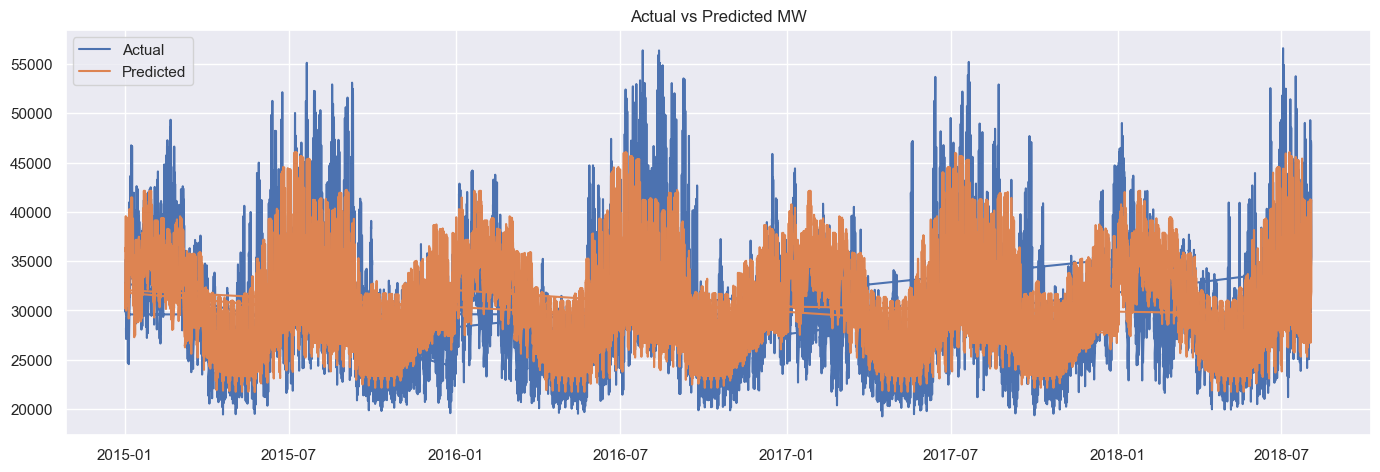

In [165]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(test.index, test['PJME_MW'], label='Actual')
plt.plot(test.index, test['prediction'], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted MW")
plt.show()


# Calculate Error

<Axes: title={'center': 'Prediction Error Distribution'}, ylabel='Frequency'>

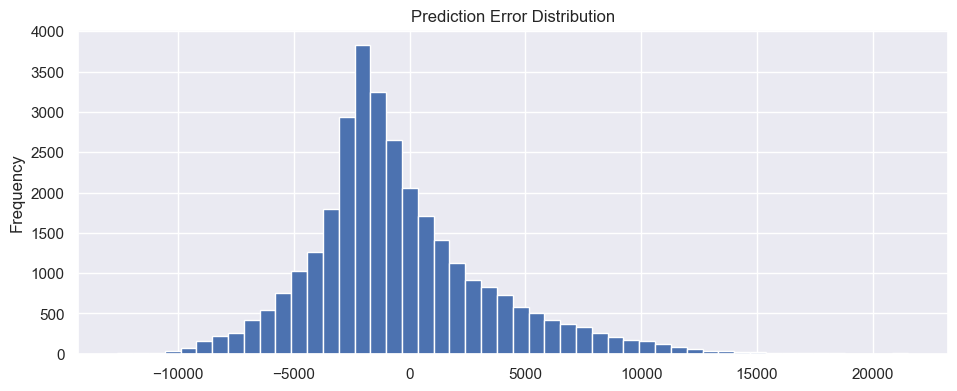

In [166]:
test['error'] = test['PJME_MW'] - test['prediction']
test['error'].plot(kind='hist', bins=50, figsize=(10,4), title='Prediction Error Distribution')


In [168]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(test['PJME_MW'], test['prediction'])
r2 = r2_score(test['PJME_MW'], test['prediction'])

print(f'MAE: {mae:.2f}')
print(f'R² Score: {r2:.4f}')


MAE: 3016.22
R² Score: 0.6298
